In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import PIL
import read_datasets as rd
import constants as CONST
from importlib import reload
reload(rd)
reload(CONST)
import base64
import pickle
import collections
import itertools, collections

In [2]:
# 
def get_web_data_single(idx): 
    drawing_raw = CONST.face_json['train_data'][idx]
    absolute_coord = rd.to_absolute(drawing_raw)
    drawing_dict = {}
    part_idx_to_show = np.unique(np.asarray(absolute_coord)[:,-1])
    for l in part_idx_to_show:
        stroke3_selected = rd.select_absolutedata(absolute_coord, label_selected=[l])
        stroke3_selected_split = rd.split_into_individual_strokes(stroke3_selected)
        drawing_dict[int(l)] = stroke3_selected_split
    return drawing_dict

png_to_drawing_dict = {}
for img_idx in CONST.all_face_indices:
    png_to_drawing_dict[img_idx] = get_web_data_single(img_idx)

# April 1st Face Second Round Release

In [20]:
# first find which pairs are missing
face_part_image_indices_missing = collections.defaultdict(list)
face_part_image_indices_missing_2 = collections.defaultdict(list)
    
dfn = CONST.face_part1_df
for part_idx in [0,1,2,4,6]:
    for image_idx in CONST.face_part_image_indices[part_idx]:
    
        l = []
        
        dfn_i = dfn[
            (dfn['part'] == part_idx) & ((dfn['image_1'] == image_idx) | (dfn['image_2'] == image_idx))
        ]
        if len(dfn_i) == 0:
            face_part_image_indices_missing[part_idx].append(image_idx)
            face_part_image_indices_missing[part_idx].append(image_idx)
        if len(dfn_i) == 1:
            face_part_image_indices_missing[part_idx].append(image_idx)

In [26]:
exists = collections.defaultdict(list)

for part_idx in [0,1,2,4,6]:
    for image_idx in CONST.face_part_image_indices[part_idx]:
    
        l = []
        
        dfn_i = dfn[
            (dfn['part'] == part_idx) & ((dfn['image_1'] == image_idx) | (dfn['image_2'] == image_idx))
        ]
        # if len(dfn_i) > 1:
        for i in dfn_i.index:
            exists[(image_idx, part_idx)].append(i)

In [27]:
selected_pairs = np.load('/raid/xiaoyuz1/amazon_turk/2022_04_04_release/png_list.npy')
for p1,p2,pidx in selected_pairs:
    exists[(p1,pidx)].append(8888)
    exists[(p2,pidx)].append(8888)

total = 0
for k,v in exists.items():
    if len(v) <= 1:
        print(k,v)
    total += len(v)

In [32]:
len(exists)*2, total

(4308, 5030)

In [34]:
5030 - 4308

722

In [4]:
for k,v in face_part_image_indices_missing.items():
    print(k, np.unique(v).shape[0])

0 232
1 131
2 234
4 44
6 402


In [26]:
# for k,v in face_part_image_indices_missing_2.items():
#     print(k, len(v))
#     for image_idx in v:
#         for _ in range(2):
#             face_part_image_indices_missing[k].append(image_idx)

0 1
6 217


In [5]:
import random

for k,v in face_part_image_indices_missing.items():
    random.shuffle(v)
    face_part_image_indices_missing[k] = v
    print(k, np.unique(v).shape[0], len(v))

0 232 233
1 131 131
2 234 234
4 44 44
6 402 619


In [16]:
# with open('/raid/xiaoyuz1/face_part_image_indices_missing.pickle', 'wb+') as f:
#     pickle.dump((face_part_image_indices_missing, face_part_image_indices_missing_2),f)
face_part_image_indices_missing, face_part_image_indices_missing_2 = None,None
with open('/raid/xiaoyuz1/face_part_image_indices_missing.pickle', 'rb') as f:
    face_part_image_indices_missing, face_part_image_indices_missing_2 = pickle.load(f)

In [6]:
feature_folder_template = "/raid/xiaoyuz1/sketch_datasets/face_features_weight_5/clip/{}"
feature_dict = rd.get_features(feature_folder_template)

In [7]:
for k,v in feature_dict.items():
    print(k, len(v))

0 572
1 334
2 572
4 104
6 572


In [12]:
from scipy.spatial import distance

In [13]:
def get_pair(image_list, image_feature_dict):
    v = image_list

    pair = []

    not_taken = [x for x in v]
    for p1 in v:
        if p1 not in not_taken:
            continue
        not_taken.remove(p1)
        dist = []

        if len(not_taken) == 0:
            for p2 in v:
                d = distance.cosine(image_feature_dict[p1], image_feature_dict[p2])
                dist.append((p2, d))
        else:
            for p2 in not_taken:
                d = distance.cosine(image_feature_dict[p1], image_feature_dict[p2])
                dist.append((p2, d))

        dist = sorted(dist, key=lambda x: x[1])
        p2,d = dist[-1]
        if len(not_taken) == 0:
            print(p1,p2)
        else:
            not_taken.remove(p2)
        pair.append((p1,p2))
    
    not_taken = [x for x in v]
    for p1,p2 in pair:
        try:
            not_taken.remove(p1)
            not_taken.remove(p2)
        except:
            print(p1,p2)
    print(not_taken)
    return pair

In [23]:
selected_pairs = []
for k in face_part_image_indices_missing.keys():
    pair = get_pair(k)
    pair = np.asarray(pair)
    pair = np.hstack([pair, (np.ones(len(pair)).astype(int) * int(k)).reshape(-1,1)])
    selected_pairs.append(pair)

194 15
194 15
[]
703 555
703 555
[]
[]
[]
364 261
364 261
[]


In [25]:
selected_pairs = np.vstack(selected_pairs)
np.random.shuffle(selected_pairs)

In [36]:
random_addition_pair = []
needed = len(selected_pairs) % 5
if needed > 0:
    needed = 5 - needed

for row_idx in np.random.choice(len(selected_pairs), needed, replace=False):
    row = np.copy(selected_pairs[row_idx]).reshape((1,-1))
    selected_pairs = np.vstack([selected_pairs, row])

In [37]:
selected_pairs[-10:]

array([[183, 360,   6],
       [642, 335,   2],
       [161, 730,   2],
       [714, 312,   2],
       [345, 378,   6],
       [508, 693,   6],
       [724, 176,   6],
       [360, 284,   0],
       [167, 319,   6],
       [ 62, 587,   1]])

In [38]:
selected_pairs.shape

(635, 3)

In [39]:
path = '/raid/xiaoyuz1/amazon_turk/2022_04_04_release/png_list.npy'
print("Write angel list to: ", path)
with open(path, 'wb') as f:
    np.save(f, selected_pairs)

Write angel list to:  /raid/xiaoyuz1/amazon_turk/2022_04_04_release/png_list.npy


In [11]:
# # The part clusters
# feature_folder_template = "/raid/xiaoyuz1/sketch_datasets/face_features/clip/{}"
# part_clusters = {}
# img_to_part_cluster = {}
# for part_idx in [0,1,2,4,6]:
#     feature_folder = feature_folder_template.format(part_idx)
#     with open(os.path.join(feature_folder, 'group', 'cluster_group.pickle'), 'rb') as f:
#         cluster_dict = pickle.load(f)
#         part_clusters[part_idx] = cluster_dict
#         for c,L in cluster_dict.items():
#             for i in L:
#                 img_to_part_cluster[(i, part_idx)] = c

In [10]:

# k = 0
# v = face_part_image_indices_missing[k]

# missing_cluster = collections.defaultdict(list)
# for img_idx in v:
#     missing_cluster[img_to_part_cluster[(img_idx, k)]].append(img_idx)
# pair = []
# for c,L in missing_cluster.items():
#     other_c = list(missing_cluster.keys())
#     other_c.remove(c)
#     for p1 in L:
#         for  
        

In [3]:
selected_pairs = np.load('/raid/xiaoyuz1/amazon_turk/2022_04_04_release/png_list.npy')

In [4]:
selected_pairs.shape

(635, 3)

In [43]:
def get_web_data(idx_pair, part_annotations, example_notes=[], part_idx_to_show=[], category_name="face"): 
    supporting = []
    for anno_idx, idx in enumerate(idx_pair):
        supporting.append(png_to_drawing_dict[idx])

    data_dict = {
        "Qtype" : "img-sketch",
        "Question" : category_name,
        "Supporting" : supporting,
        "PartsToAnnotate" : part_annotations,
        "ExampleNotes" : example_notes,
    }
    return data_dict


angel_data = []
indices_used = []

for task_idx in range(0,60):
    one_hit = selected_pairs[task_idx*5:(task_idx+1) * 5]
    indices_used.append(one_hit)
    hit_data = []

    for pair_idx, (img1, img2, part_idx) in enumerate(one_hit):
        
        pair = [img1,img2]
        part_annotations = [[int(part_idx), CONST.parts_idx_dict[part_idx], ["", ""], "a/an"]]
        pair_data = get_web_data(pair, part_annotations, category_name="face")
        hit_data += [pair_data]
    # print("\n")
    y = json.dumps(hit_data)
    dataBytes = y.encode("utf-8")
    encoded = base64.b64encode(dataBytes)
    angel_data.append(str(encoded)[2:-1])

In [44]:
amazon_data = {
    "base64" : angel_data,
}
df = pd.DataFrame.from_dict(amazon_data)
df.to_csv('/raid/xiaoyuz1/amazon_turk/2022_04_04_release/png_list.csv', index=False)  

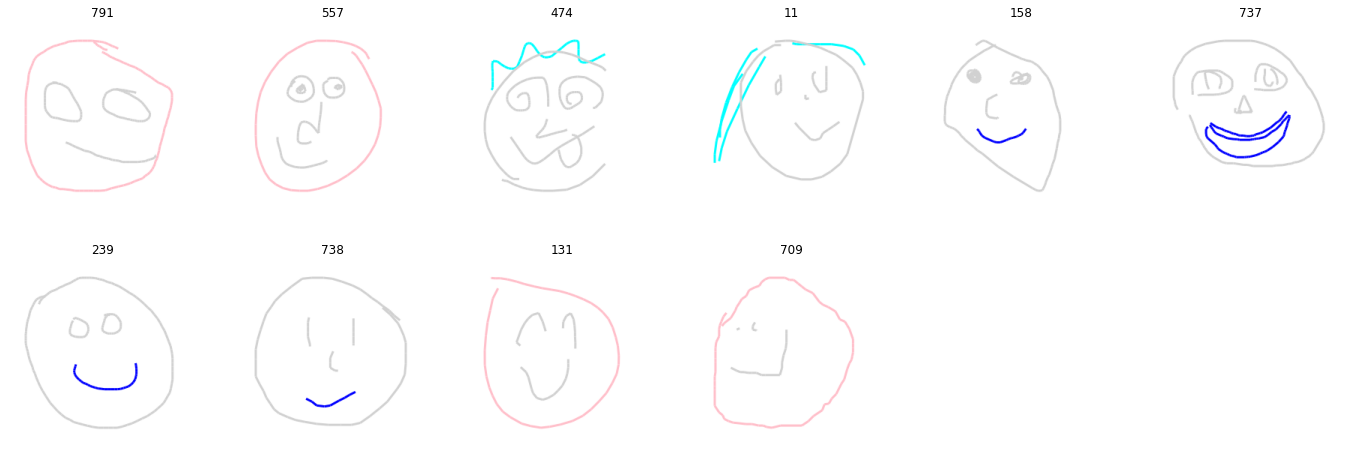

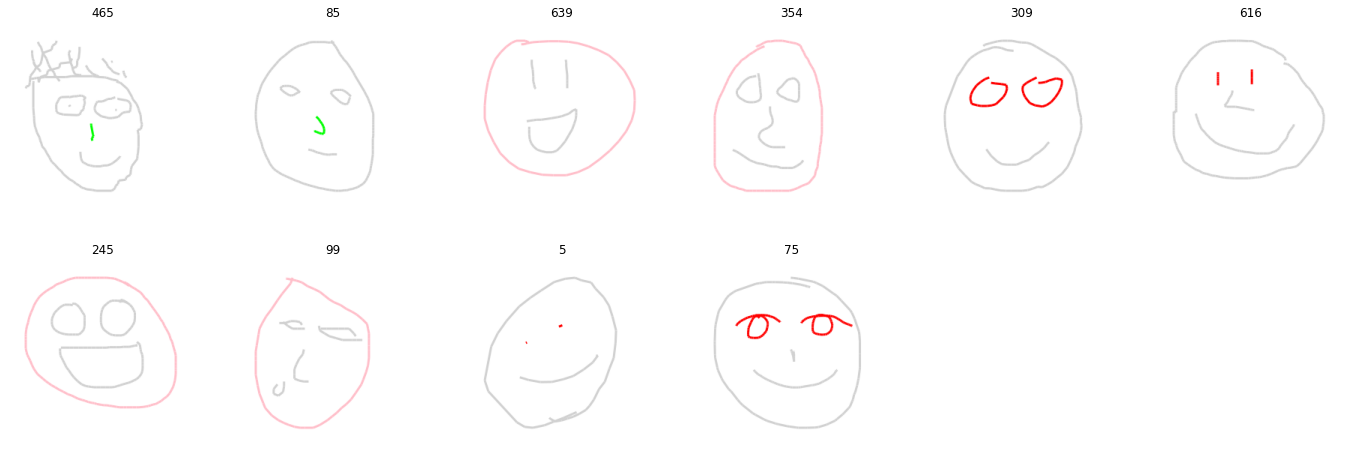

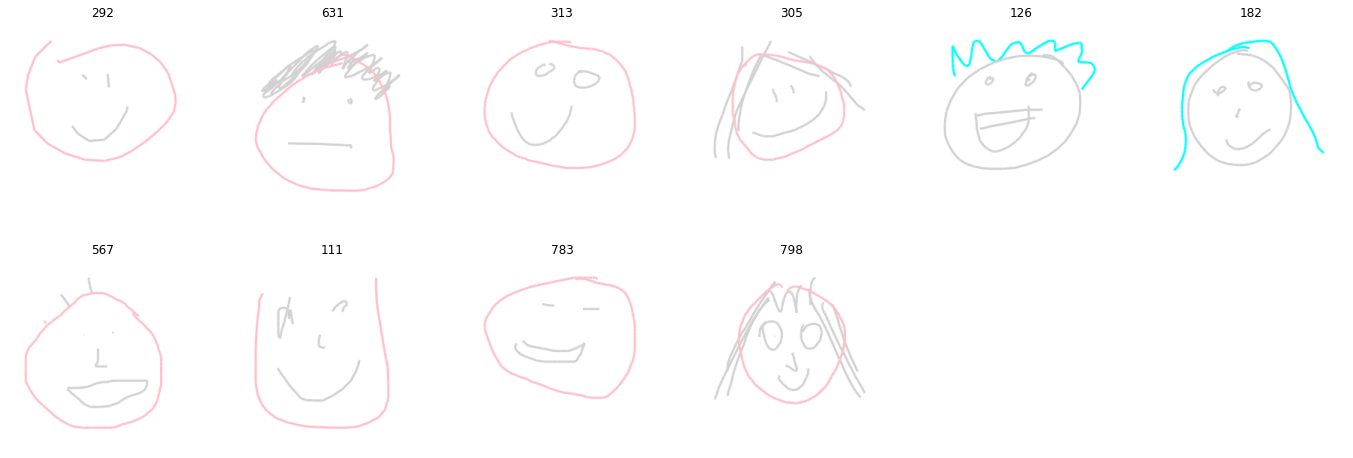

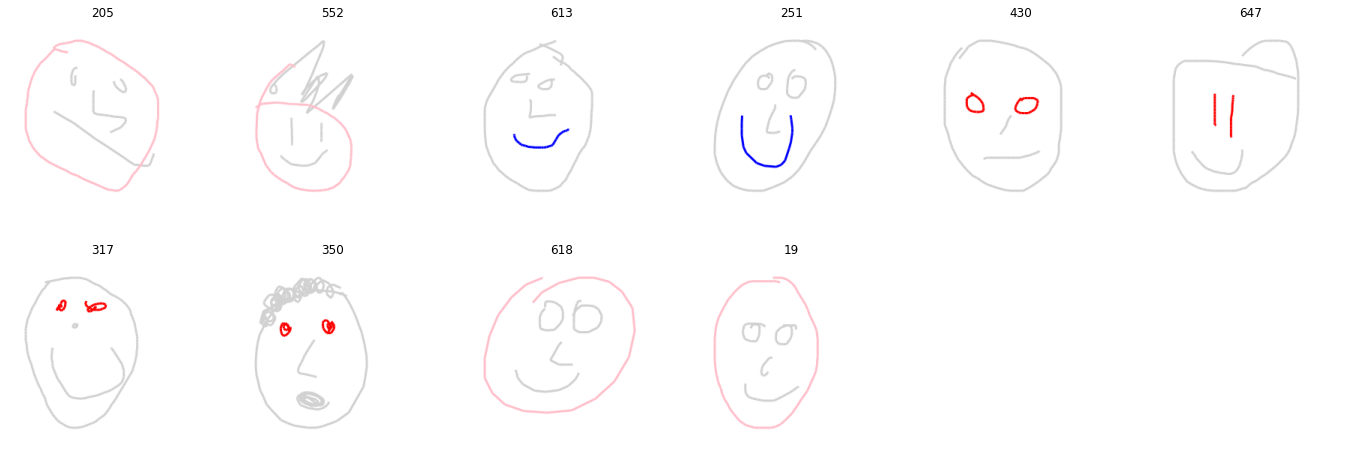

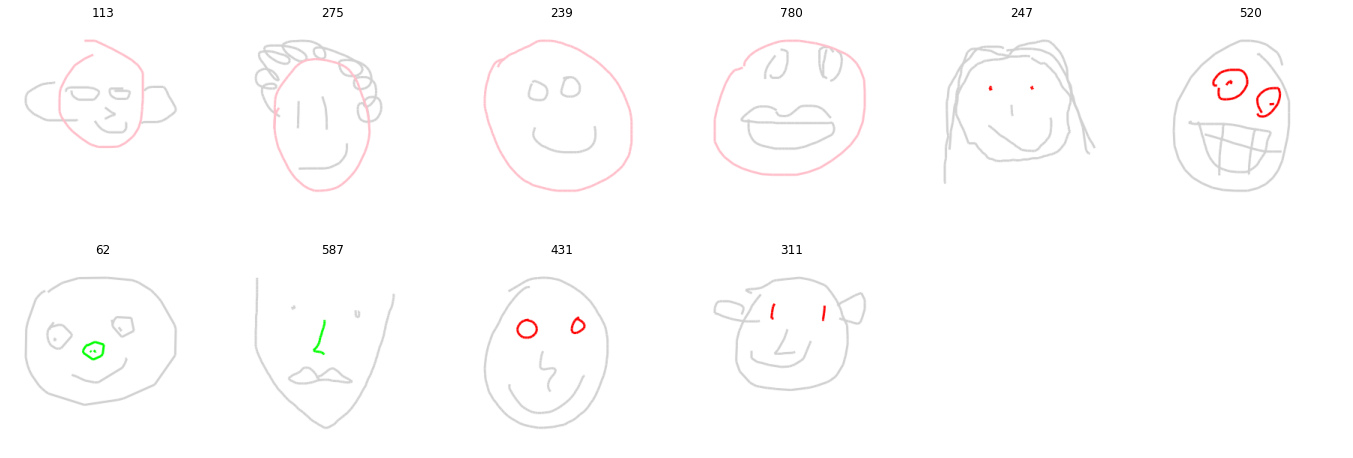

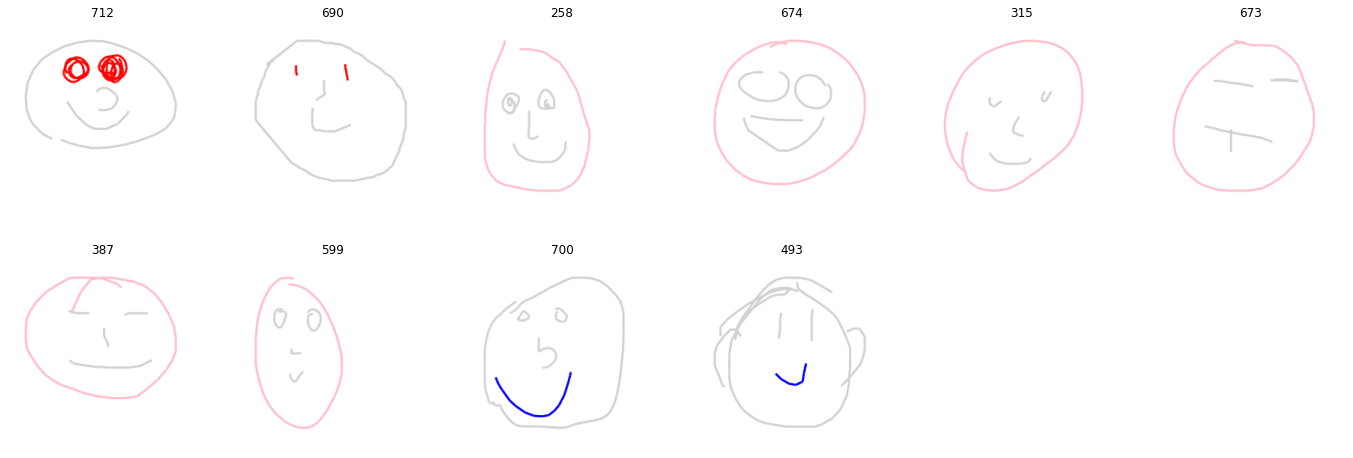

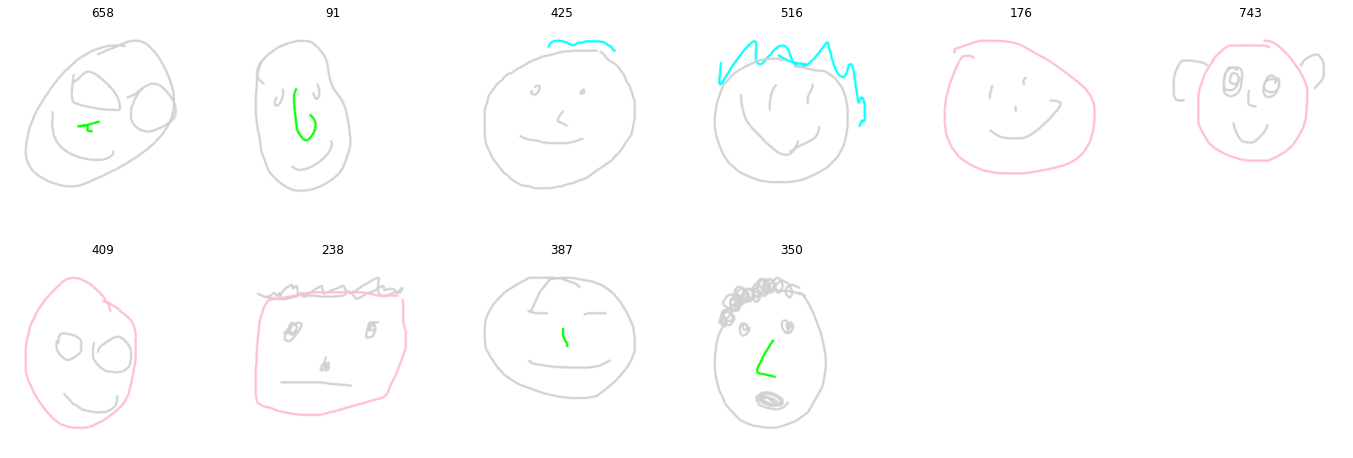

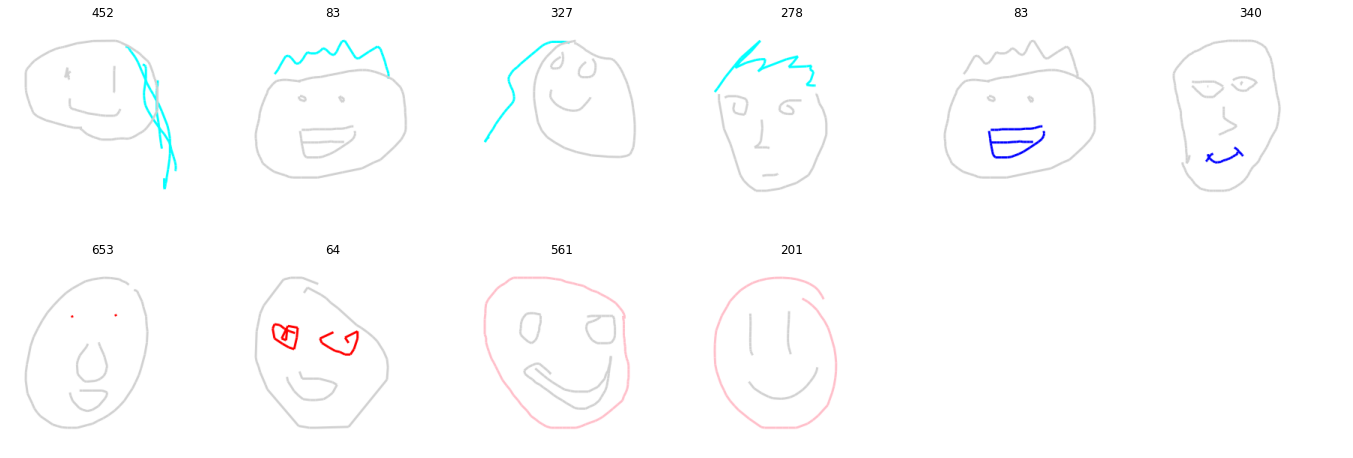

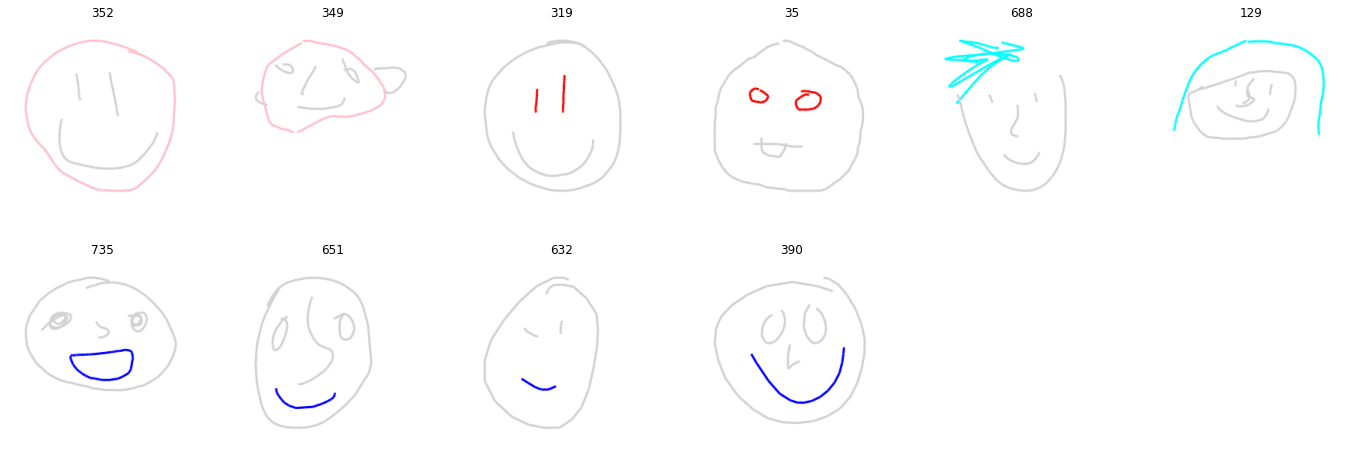

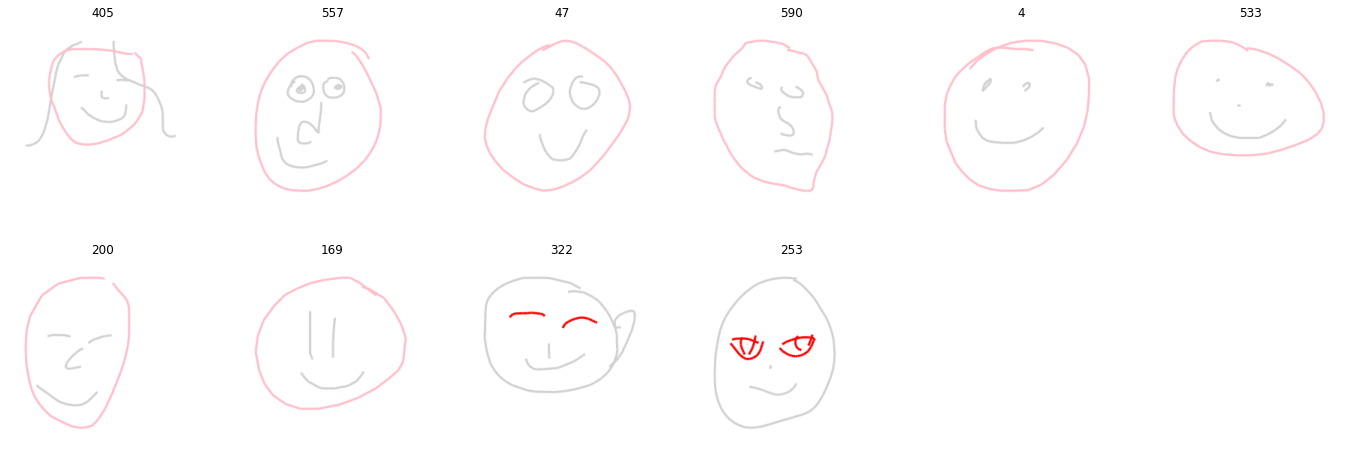

In [35]:
for i in range(10,20):
    one_hit = selected_pairs[(0+i)*5:(0+i+1) * 5]
    indices = []
    titles = []
    part_indices_plot = []
    for p1,p2,part_idx in one_hit:
        indices += [p1,p2]
        titles += [str(p1), str(p2)]
        part_indices_plot += [[part_idx],[part_idx]]

    rd.show_these_sketches(
        indices, 
        titles, 
        part_indices_plot, 
        num_pngs_per_row = 6,
        row_figsize = 4,
        column_figsize = 4,
    )

# Generate pairs

In [16]:
feature_folder_parent = "/raid/xiaoyuz1/sketch_datasets/face_features/clip"
pairs_list = []
for part_idx in parts_idx:
    feature_folder = os.path.join(feature_folder_parent, str(part_idx))
    pairs = np.load(os.path.join(feature_folder, 'group', 'group.npy'))
    np.random.shuffle(pairs)
    np.random.shuffle(pairs)

    
    pairs_list += [np.hstack([
        pairs, 
        (np.ones(len(pairs)).astype(int) * part_idx).reshape((-1,1))
    ])]

selected_pairs = []
i = 0
round_num = 0
count = [len(x) for x in pairs_list]
while True:
    if len(count) == 0:
        break
    j = i % len(count)
    try:
        selected_pairs.append(pairs_list[j][round_num])
    except:
        print(i,j,count,round_num)
        raise
    
    i += 1
    if j == len(count)-1:
        round_num += 1
    
    count[j] -= 1
    if count[j] == 0:
        count.pop(j)
        pairs_list.pop(j)

selected_pairs = np.vstack(selected_pairs)
# np.random.shuffle(selected_pairs)
print(selected_pairs.shape)

(1883, 3)


(572,)
(334,)
(572,)
(104,)
(355,)


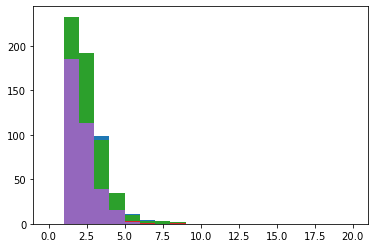

In [17]:
for part_idx in parts_idx:
    labs, cts = np.unique(selected_pairs[:,:2][selected_pairs[:,-1]==part_idx].reshape(-1,), return_counts=True)
    print(labs.shape)
    plt.hist(cts, bins=np.arange(0,21))

# Generate release csv (pre April 1st)

In [8]:
selected_pairs = np.load('/raid/xiaoyuz1/amazon_turk/2022_03_21_release/png_list.npy')

In [9]:
def get_web_data(idx_pair, part_annotations, example_notes=[], part_idx_to_show=[], category_name="face"): 
    supporting = []
    for anno_idx, idx in enumerate(idx_pair):
        supporting.append(png_to_drawing_dict[idx])

    data_dict = {
        "Qtype" : "img-sketch",
        "Question" : category_name,
        "Supporting" : supporting,
        "PartsToAnnotate" : part_annotations,
        "ExampleNotes" : example_notes,
    }
    return data_dict


angel_data = []
indices_used = []

for task_idx in range(300,376):
    one_hit = selected_pairs[task_idx*5:(task_idx+1) * 5]
    indices_used.append(one_hit)
    hit_data = []

    for pair_idx, (img1, img2, part_idx) in enumerate(one_hit):
        
        pair = [img1,img2]
        part_annotations = [[int(part_idx), parts_idx_dict[part_idx], ["", ""], "a/an"]]
        pair_data = get_web_data(pair, part_annotations, category_name="face")
        hit_data += [pair_data]
    # print("\n")
    y = json.dumps(hit_data)
    dataBytes = y.encode("utf-8")
    encoded = base64.b64encode(dataBytes)
    angel_data.append(str(encoded)[2:-1])

In [19]:
len(selected_pairs) // 5

376

In [20]:
!mkdir /raid/xiaoyuz1/amazon_turk/2022_03_24_release_2

In [27]:
amazon_data = {
    "base64" : angel_data,
}
df = pd.DataFrame.from_dict(amazon_data)
df.to_csv('/raid/xiaoyuz1/amazon_turk/2022_03_24_release_2/png_list.csv', index=False)  

In [ ]:
# path = '/raid/xiaoyuz1/amazon_turk/2022_03_21_release/png_list.npy'
# print("Write angel list to: ", path)
# with open(path, 'wb') as f:
#     np.save(f, selected_pairs)

In [9]:
# not_there = []
# for i in range(800):
#     if '{}.png'.format(str(i)) not in total_pics:
#         not_there.append(i)
# not_there_titles = ["{}".format(i) for i in not_there]
# not_there_part_indices = [[0,1,2,4,6] for _ in not_there]
# show_these_sketches(
#     not_there, 
#     not_there_titles, 
#     not_there_part_indices, 
#     num_pngs_per_row = 5,
#     row_figsize = 4,
#     column_figsize = 4,
# )

In [63]:
with open('/raid/xiaoyuz1/face_cluster.pickle', 'wb+') as f:
    pickle.dump(groups,f)

# Results

In [9]:
# The part clusters
feature_folder_template = "/raid/xiaoyuz1/sketch_datasets/face_features/clip/{}"
part_clusters = {}
img_to_part_cluster = {}
for part_idx in parts_idx:
    feature_folder = feature_folder_template.format(part_idx)
    with open(os.path.join(feature_folder, 'group', 'cluster_group.pickle'), 'rb') as f:
        cluster_dict = pickle.load(f)
        part_clusters[part_idx] = cluster_dict
        for c,L in cluster_dict.items():
            for i in L:
                img_to_part_cluster[(i, part_idx)] = c

In [10]:
# potential_count_for_cluster = collections.defaultdict(lambda: collections.defaultdict(int))

# for img1,img2,part_idx in selected_pairs:
#     potential_count_for_cluster[part_idx][img_to_part_cluster[(img1, part_idx)]] += 1
#     potential_count_for_cluster[part_idx][img_to_part_cluster[(img2, part_idx)]] += 1

# for part_idx in sorted(list(potential_count_for_cluster.keys())):
#     d = potential_count_for_cluster[part_idx]
#     for c in sorted(list(d.keys())):
#         print(part_idx, " | ", c, " | ", d[c]/len(part_clusters[part_idx][c]))

In [11]:
result_folders = [
    '/raid/xiaoyuz1/amazon_turk/2022_03_17_release',
    '/raid/xiaoyuz1/amazon_turk/2022_03_21_release',
    '/raid/xiaoyuz1/amazon_turk/2022_03_22_release',
    '/raid/xiaoyuz1/amazon_turk/2022_03_23_release',
    '/raid/xiaoyuz1/amazon_turk/2022_03_23_release_2',
    '/raid/xiaoyuz1/amazon_turk/2022_03_24_release',
]

result_csv_files = [
    'Batch_4693878_batch_results.csv',
    'Batch_4696268_batch_results.csv',
    'Batch_4697008_batch_results.csv',
    'Batch_4697913_batch_results.csv',
    'Batch_4698198_batch_results.csv',
    'Batch_4698860_batch_results.csv',
]

dfs = []
selected_pairss = []
df_inputs = []

for i,(result_folder,csv_file) in enumerate(zip(result_folders, result_csv_files)):
    result_fname = os.path.join(result_folder,csv_file)
    dfs += [pd.read_csv(result_fname)]
    if i == 0:
        selected_pairss += [np.load(os.path.join(result_folder, 'png_list.npy'))]
    else:
        selected_pairss += [np.load('/raid/xiaoyuz1/amazon_turk/2022_03_21_release/png_list.npy')]
    df_inputs += [pd.read_csv(os.path.join(result_folder, 'png_list.csv'))]

df_idx_to_task_idxs = []
for j in range(len(dfs)):
    df = dfs[j]
    df_input = df_inputs[j]
    selected_pairs = selected_pairss[j]
    
    df_idx_to_task_idx = np.zeros((len(df), 5, 3))
    for i in range(len(df)):
        task_idx = np.where(df_input['base64'] == df.iloc[i]['Input.base64'])[0][0]
        if j == 2:
            task_idx += 50
        if j == 3:
            task_idx += 150
        if j == 4:
            task_idx += 200
        if j == 5:
            task_idx += 250
        if j == 6:
            task_idx += 300
        df_idx_to_task_idx[i] = selected_pairs[task_idx*5:(task_idx+1) * 5]
    df_idx_to_task_idx = df_idx_to_task_idx.astype(int)
    print(df_idx_to_task_idx.shape)
    
    df_idx_to_task_idxs += [df_idx_to_task_idx]

(100, 5, 3)
(50, 5, 3)
(100, 5, 3)
(50, 5, 3)
(50, 5, 3)
(50, 5, 3)


In [12]:
def print_money(df):
    def money(s):
        return ((s/60)/60) * 15
    for s in df["WorkTimeInSeconds"].describe():
        print('{:0.2f} sec = $ {:0.2f}'.format(s, money(s)))
    sns.displot(df, x="WorkTimeInSeconds", bins=20)

def print_worker(df):
    ids, count = np.unique(df['WorkerId'].to_numpy(), return_counts=True)
    print("Number of unique workers: ", len(ids))
    fig = plt.figure()
    fig.patch.set_alpha(1)  # solution
    plt.hist(count, bins=np.arange(0,14))
    wid_to_count = dict(zip(ids, count))
    return ids

def print_feedback(df):
    ids, count = np.unique(df['WorkerId'].to_numpy(), return_counts=True)
    wid_to_count = dict(zip(ids, count))

    for i in df[df['Answer.feedback'].notnull()].index:
        wid = df.iloc[i]['WorkerId']
        print(df.iloc[i]['WorkerId'], wid_to_count[wid])
        print(df.iloc[i]['Answer.feedback'])
        print("\n")
    
def show_row(j, i):
    df = dfs[j]
    df_input = df_inputs[j]
    df_idx_to_task_idx = df_idx_to_task_idxs[j]
    
    png_indices = []
    png_titles = []
    part_indices = []
    
    row = df.iloc[i]
    # task_idx = np.where(df_input['base64'] == row['Input.base64'])[0][0]
    one_hit = df_idx_to_task_idx[i]
    for anno_idx,(img1,img2,part_idx) in zip(range(1, 6),one_hit):
        k1 = "Answer.inputAnnotationName_{}-{}__{}".format(anno_idx, part_idx, 1)
        k2 = "Answer.inputAnnotationName_{}-{}__{}".format(anno_idx, part_idx, 2)

        title1 = "{} {} \n({})".format(row[k1], parts_idx_dict[part_idx],str(img1))
        title2 = "{} {} \n({})".format(row[k2], parts_idx_dict[part_idx],str(img2))

        png_indices += [img1,img2]
        png_titles += [title1,title2]
        part_indices += [[part_idx],[part_idx]]
    print(row['WorkerId'])
    show_these_sketches(png_indices, png_titles, part_indices)

A22HIX1M4QXZBB


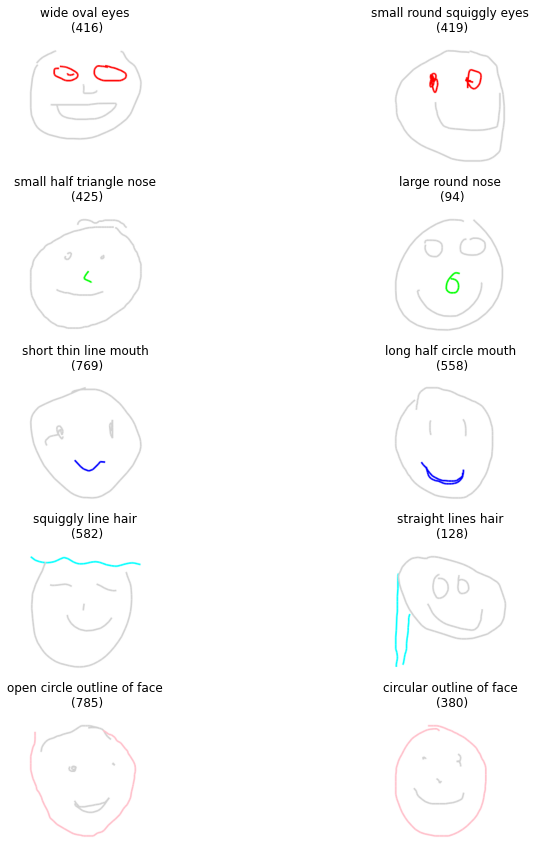

A38DXFI1TZA295


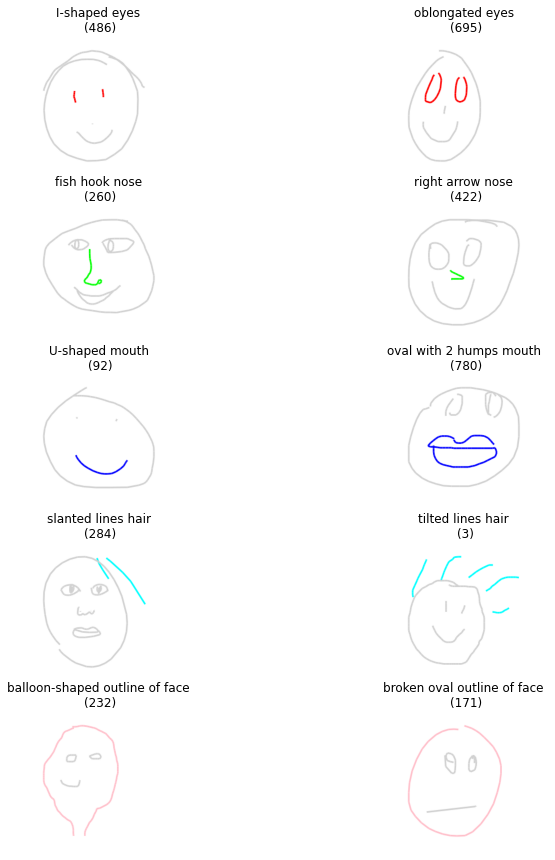

AKQAI78JTXXC9


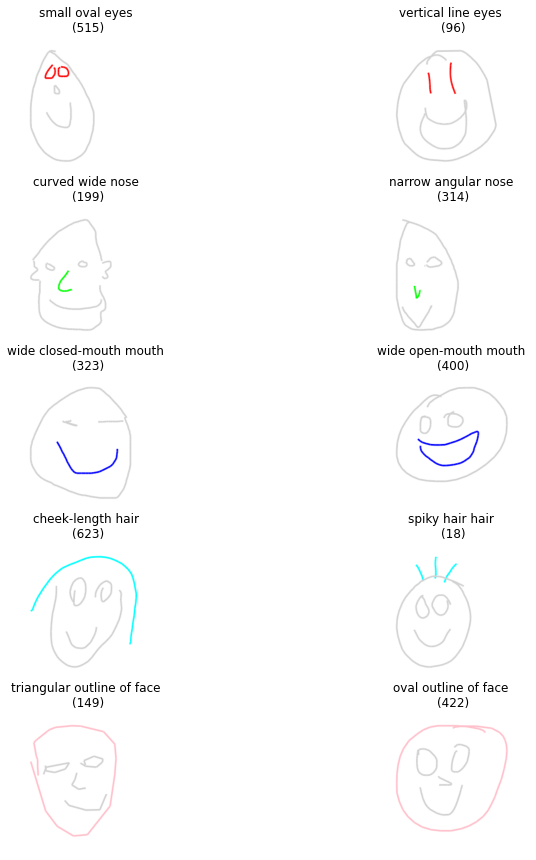

APRZ7BR8C0ZMQ


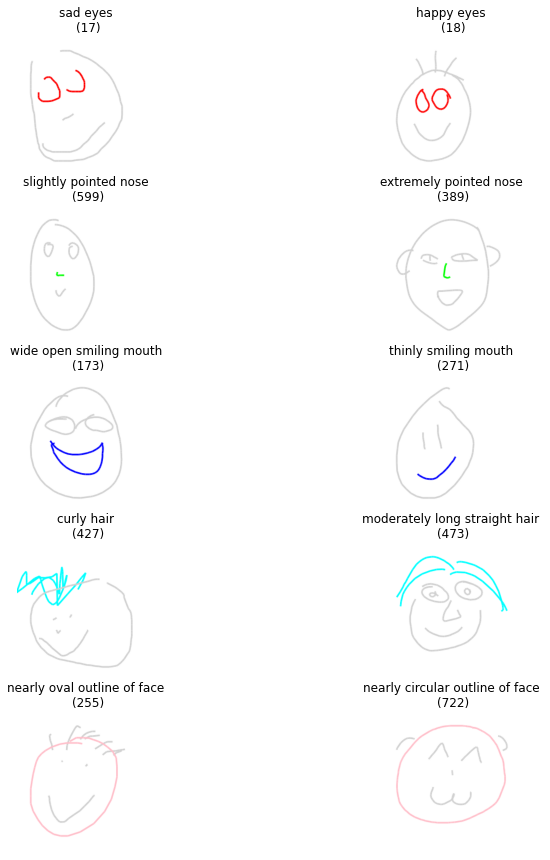

A1DMXEJGJY02E1


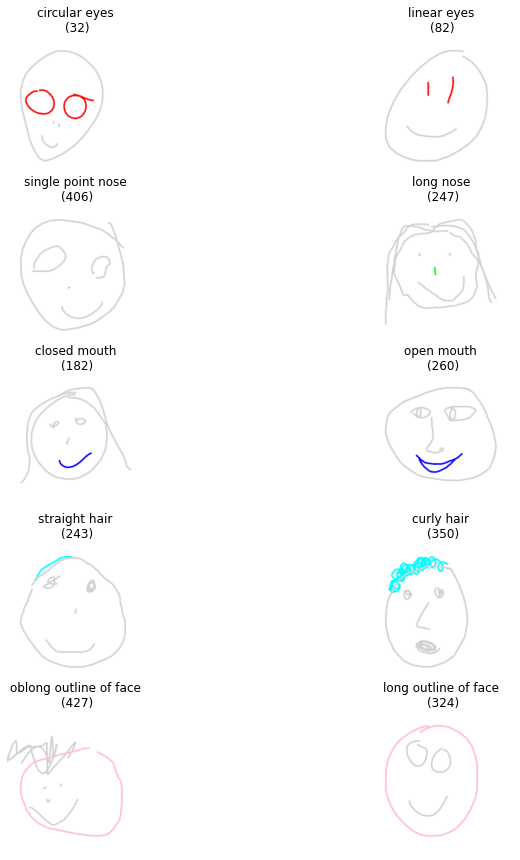

In [17]:
for i in range(20,25):
    show_row(1,i)

In [30]:
# print_feedback(dfs[-1])

50.00 sec = $ 0.21
951.86 sec = $ 3.97
674.77 sec = $ 2.81
129.00 sec = $ 0.54
522.00 sec = $ 2.17
751.00 sec = $ 3.13
1061.75 sec = $ 4.42
3287.00 sec = $ 13.70


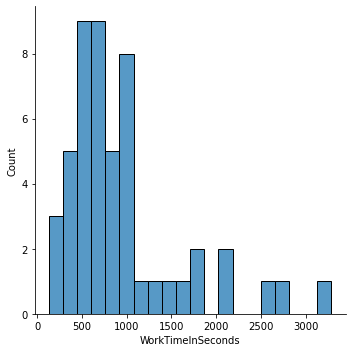

In [21]:
print_money(dfs[1])

In [27]:
def worker_avg_time(df):
    ids, count = np.unique(df['WorkerId'].to_numpy(), return_counts=True)
    wid_to_count = dict(zip(ids, count))
    
    for w in df["WorkerId"].unique():
        print(w, "done: ", wid_to_count[w], ", average time: ", df[df["WorkerId"]==w]["WorkTimeInSeconds"].mean())

worker_avg_time(dfs[5])

AHYTT3T8W9Y9Y done:  11 , average time:  2168.7272727272725
A2OVX9UW5WANQE done:  7 , average time:  1930.7142857142858
A12R2U6TBB3OOG done:  4 , average time:  2648.25
A2QX3YJXAAHHVV done:  7 , average time:  2365.1428571428573
A1SX8IVV82M0LW done:  1 , average time:  89.0
A1DMXEJGJY02E1 done:  3 , average time:  275.6666666666667
APRZ7BR8C0ZMQ done:  4 , average time:  625.5
A2K6VG008QFOPN done:  2 , average time:  3209.0
A1VMPZVVVZUCS4 done:  2 , average time:  2217.5
A38DXFI1TZA295 done:  3 , average time:  3325.3333333333335
AAQREZOK13OV7 done:  4 , average time:  1797.75
A1FYWSPNO7KN1O done:  1 , average time:  753.0
A2541C8MY0BYV3 done:  1 , average time:  1425.0


Number of unique workers:  35
Number of unique workers:  33
Number of unique workers:  26
Number of unique workers:  20
Number of unique workers:  18
Number of unique workers:  13
(63,)


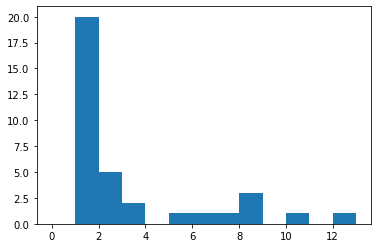

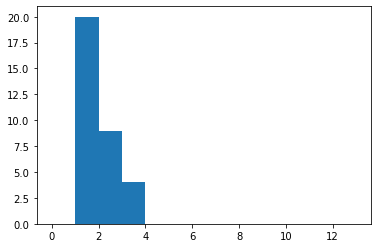

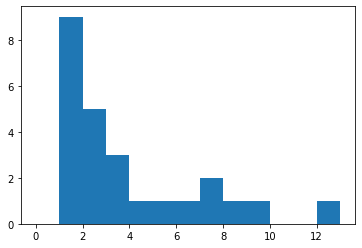

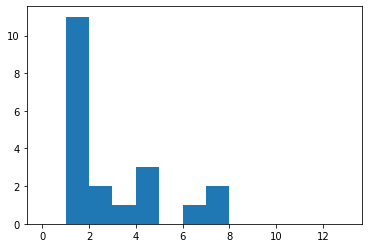

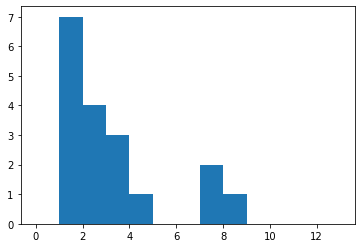

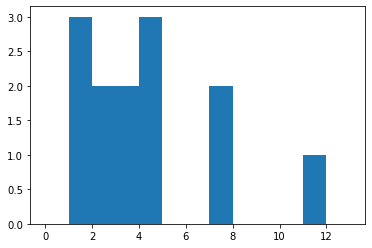

In [33]:
workers = []
for df in dfs:
    ids = print_worker(df)
    workers += list(ids)
print(np.unique(workers).shape)

In [13]:
def text_annotation(df, df_idx_to_task_idx, data=None):
    df_idx_to_task_idx = df_idx_to_task_idx.astype(int)
    if data is None:
        data = collections.defaultdict(list)
    for i in range(len(df)):
        row = df.iloc[i]
        one_hit = df_idx_to_task_idx[i]
        for anno_idx,(img1,img2,part_idx) in zip(range(1, 6),one_hit):
            k1 = "Answer.inputAnnotationName_{}-{}__{}".format(anno_idx, part_idx, 1)
            k2 = "Answer.inputAnnotationName_{}-{}__{}".format(anno_idx, part_idx, 2)
            
            data[(img1, part_idx)].append(row[k1])
            data[(img2, part_idx)].append(row[k2])
    return data

In [14]:
text_data = None
for j in range(len(dfs)):
    df = dfs[j]
    df_idx_to_task_idx = df_idx_to_task_idxs[j]
    text_data = text_annotation(df, df_idx_to_task_idx, data=text_data)

In [19]:
len(text_data)

1248

In [16]:
text_data_by_cluster = collections.defaultdict(lambda : collections.defaultdict(list))
for k,v in text_data.items():
    try:
        c = img_to_part_cluster[k]
        text_data_by_cluster[k[1]][c] += v
    except:
        continue

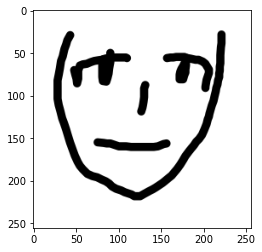

In [64]:
i = 625
drawing_raw = obj['train_data'][i]
drawing_new = rd.transform_spg_2_quickdraw(drawing_raw, label_selected=[])
vector_part = []
for stroke in drawing_new:
    stroke = np.asarray(stroke).T
    vector_part.append(stroke)

render_img(vector_part, show=True)

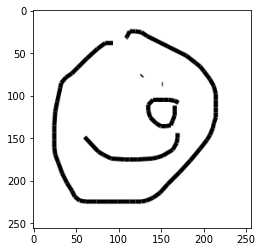

In [23]:
drawing_raw = obj['train_data'][670]
image_data = rd.transform_spg_2_svg_png(
    drawing_raw, output_dim=(256,256), draw_color=False, label_selected=[], stroke_width=5, color_selected=[])
image = PIL.Image.fromarray(image_data).convert("L")
arr = np.asarray(image)
plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.show()